In order to successfully complete this assignment you need to:
1. Participate both individually and in groups during class.
2. Submit this notebook to the `exercise` folder in your `cmse802-yourlastname` repository by 10pm __the SAME DAY of the class__. Late assignment will receive <=80% of the grade.

### <p style="text-align: left;"> &#9989; Put your name here: Pavan Yachamaneni </p>

# __Neural Style Transfer__

<img src= "https://www.image-net.org/static_files/index_files/logo.jpg" width="50%">

From: [ImageNet](https://www.image-net.org/index.php)

This assignment is modified from the [Neural Style Transfer tutorial from Tensorflow](https://www.tensorflow.org/tutorials/generative/style_transfer).

## Learning objectives

At the end of the exercise, you should be able to:
- Reuse a pre-trained model for another purpose.
- Make connections between input, the learned activations, and outputs.

## Outline

1. [Transfer learning and VGG19](#tl)
1. [Apply the approaches on your own images](#cnn)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
import torchvision.models as models

import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
device

device(type='cuda')

----
<a name="tl"></a>
# 1. Transfer learning and VGG19

## 1.1 Transfer learning

The general idea of __transfer learning__ is to transfer knowlege from an existing model for one task to perform another related or unrelated task. Below is an example where models (Efficient Net, VGG, ResNet) pretrained with IMANGENET datasets are reused to classify cancer types from histological images:

<img src= "https://dfzljdn9uc3pi.cloudfront.net/2021/cs-348/1/fig-5-2x.jpg" width="100%">

From: [ Bhatt​, Ganatra, Kotecha (2021) PeerJ Comp Sci](https://doi.org/10.7717/peerj-cs.348)

## 1.2 VGG19 architecture

&#9989; <font color=blue>**DO THIS:**</font> Here, we will be using pre-trained [VGG19](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html#torchvision.models.vgg19), retain part of it, for neural style transfer. First, let's load VGG19 and check out its architecture:

In [3]:
cnn = models.vgg19(pretrained=True).to(device).eval()
print(cnn)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## 1.3 VGG19 for classification


&#9989; <font color=blue>**DO THIS:**</font> In the preclass assignment, we have defined the `load_image` function and the `show_image` function. Run the codes below to load the functions

In [4]:
imsize = 256
resize = transforms.Compose([
    transforms.Resize([imsize,imsize]),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def load_image(img_url):
    '''Load image based on url'''
    image    = Image.open(requests.get(img_url, stream=True).raw)    
    image = resize(image).unsqueeze(0)
    return image.to(device, torch.float)
    
  

In [5]:
def show_image(image, title):
    plt.figure()
    if len(image.shape) > 3: 
        image = torch.squeeze(image, axis=0)
    image = torch.permute(image,(1,2,0))
    plt.figure(figsize=(10,10)); plt.imshow(image); plt.title(title); plt.show()

&#9989; <font color=blue>**DO THIS:**</font> First, use the above two functions to load and show the content and style images that will be used throughout this exercise. Store the content image into a variable called `x_content` and the style image into the variable `x_style`

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

In [7]:
content_url = "https://admissions.msu.edu/-/media/assets/admissions/images/homepage/beaumont-tower-virtual-tour.jpg"
style_url   = "https://cdn.pocket-lint.com/r/s/1200x630/assets/images/137952-games-review-the-legend-of-zelda-breath-of-the-wild-review-image1-tbvqza2wel.jpg"

# put code below to load and show the cotent and style images
x_content = load_image(content_url)
x_style = load_image(style_url)

<Figure size 432x288 with 0 Axes>

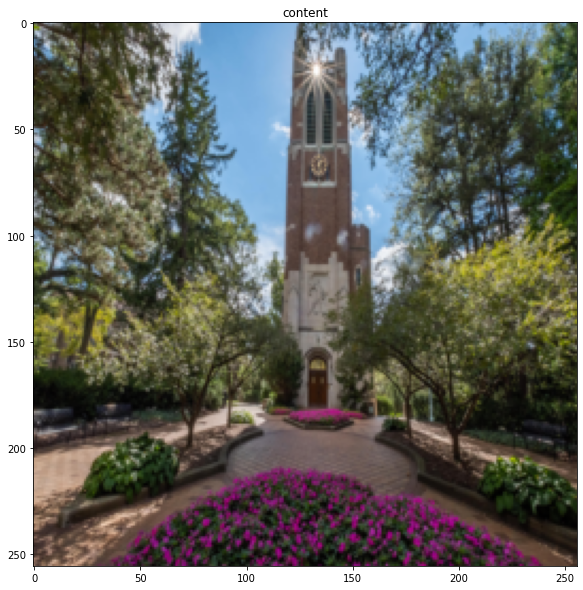

In [8]:

show_image(x_content.detach().cpu(),"content")

<Figure size 432x288 with 0 Axes>

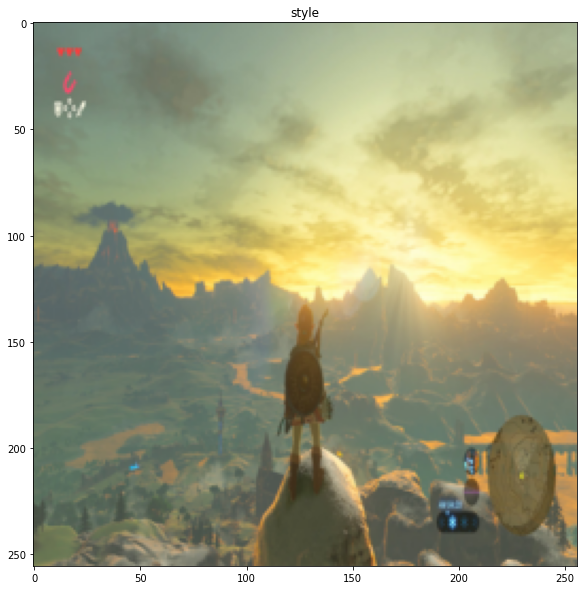

In [9]:
show_image(x_style.detach().cpu(),"style")

&#9989; <font color=blue>**DO THIS:**</font> Since VGG19 is an object-detection and classification model, let's see what object is detected in the content image `x_content`. Run the code below and write code to figure out how many classes there are based on `VGG_predition_numpy`. Provide comments as indicated.

In [10]:
VGG_prediction =cnn(x_content)                        #What does this line do
VGG_prediction_numpy = VGG_prediction.detach().cpu().numpy()   #What does this line do

#put your code here
VGG_prediction_numpy.shape

(1, 1000)

&#9989; <font color=blue>**DO THIS:**</font> Run the following cell to print out the top five predictions of the content image `x_content`.

In [12]:
predicted_class_top5 = np.argsort(np.squeeze(VGG_prediction_numpy))[-5:]     #What is this line doing
predicted_class_top5
lines = []
with open('imagenet1000_clsidx_to_labels.txt', 'r') as fp:
    line_numbers = predicted_class_top5
    for i, line in enumerate(fp):
        if i in line_numbers:
           lines.append([line.strip()])
           
print(lines)

[["442: 'bell cote, bell cot',"], ["497: 'church, church building',"], ["682: 'obelisk',"], ["839: 'suspension bridge',"], ["888: 'viaduct',"]]


&#9989; <font color=blue>**DO THIS:**</font> Write code below that predicts the classes of the style image `x_style`.

In [13]:
# put your codes here
VGG_prediction_1 =cnn(x_style)                        #What does this line do
VGG_prediction_numpy_1 = VGG_prediction_1.detach().cpu().numpy()   #What does this line do

In [14]:
predicted_class_top5 = np.argsort(np.squeeze(VGG_prediction_numpy_1))[-5:]     #What is this line doing
predicted_class_top5
lines = []
with open('imagenet1000_clsidx_to_labels.txt', 'r') as fp:
    line_numbers = predicted_class_top5
    for i, line in enumerate(fp):
        if i in line_numbers:
           lines.append([line.strip()])
           
print(lines)

[["562: 'fountain',"], ["672: 'mountain tent',"], ["701: 'parachute, chute',"], ["970: 'alp',"], ["979: 'valley, vale',"]]


&#9989; <font color=red>**QUESTION:**</font> Do the predictions make sense? 

<font size=+3>&#9998;</font> YEs they do, they are giving highest probabilities among 1000 classes

----
<a name="tl"></a>
# 2. A small detour: the second way of creating a neural network via Pytorch

# 2.1 Creating a network model with nn.sequential

The neural style transfer code is quite complicted. In order to understand it, we first need to take a look at the two ways of creating a neural network with Pytorch. They are 
 - creating the neural network via torch.nn.Module (what we have used)
 - creating the neural network via torch.nn.sequential (new)
 
The first way (as implemented in the following cell) is what we have been using so far. You must have been very familiar with it.

In [15]:
import torch.nn as nn
import torch.nn.functional as F
class Classifier_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32**2*3,300)
        self.fc2 = nn.Linear(300,100)
        self.fc3 = nn.Linear(100,10)
        
    
        
    def forward(self,x):
        type(x)
        x = x.view(x.shape[0],-1)
        type(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(x,dim=1)
        return x
net = Classifier_NN()

Taking a look at the model summary

In [16]:
from torchsummary import summary
summary(net.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         921,900
            Linear-2                  [-1, 100]          30,100
            Linear-3                   [-1, 10]           1,010
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 3.64
Estimated Total Size (MB): 3.65
----------------------------------------------------------------


&#9989; <font color=blue>**DO THIS:**</font> With some sacrifice of the flexibility, the same network can be created via the nn.Sequential module. Run the code below to create another neural network called `model` and print it to see its composition.

In [17]:
import torch.nn as nn
model = nn.Sequential(
          nn.Flatten(),
          nn.Linear(32**2*3,300),
          nn.ReLU(),
          nn.Linear(300,100),
          nn.ReLU(),
          nn.Linear(100,10),
          nn.Softmax()
        )
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=300, bias=True)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=10, bias=True)
  (6): Softmax(dim=None)
)


&#9989; <font color=blue>**DO THIS:**</font> Print out the summary of `model` to confirm that it defines the same neural network as `net`

# 2.2 Adding additional layers to an existing neural net

&#9989; <font color=blue>**DO THIS:**</font> Conveniently, after the model is created, you can still add new layers to it. Say we want to append a ReLU layer to the end of the network `model` we just created. We only need to issue the following command.

In [18]:
model.add_module('ReLU',nn.ReLU())

We have been talking about layers a lot -- you have seen many different types of layers `nn.ReLU()`, `nn.Conv2d()`, `nn.Linear()`, etc.. But what are the data type of an NN layer in Python? Are they lists, dictionaries, sets or functions? The answer is, none of the above: they are **class object**! Each layer is defined as a class object. And a neural network is nothing but a sequence of class objects. In the end, the network itself is a class object (the definition of object is just flexible enough to allow a list of objects to be an object itself)

Knowing this fact is very important, since it allows us define customized layers. Say we want to define a layer that centralizes the input, i.e., subtracting the mean of the input from each of its entry. Then all we need to do is to define the following class and append it to `model`.

&#9989; <font color=blue>**DO THIS:**</font> provide comments as indicated.

In [19]:
class Centralization_layer(nn.Module):
    def __init__(self): 
        super().__init__()
        

    def forward(self,x): # x is the input of this layer
        return x - x.mean() #What does this line do?
    
model.add_module('Centralization',Centralization_layer()) #What does this line do?

&#9989; <font color=blue>**DO THIS:**</font> Run the following cell to test whether the new layer is effective (does what it is supposed to do).

In [20]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=300, bias=True)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=10, bias=True)
  (6): Softmax(dim=None)
  (ReLU): ReLU()
  (Centralization): Centralization_layer()
)

In [21]:
image = torch.rand(1,3,32,32) # create a random test image 
output = model(image.to(device))
assert torch.abs(output.mean())<1e-8 #what does this line do?

RuntimeError: ignored

&#9989; <font color=red>**QUESTION:**</font> How can you tell whether the centralization layer is effective based on the ouput of the above cell? 

<font size=+3>&#9998;</font> It output very low value

----
<a name="nst"></a>
# 3. Implementing neutral style transfer functions

## 3.1 Define the normalization layer

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into layers of the network.

In [22]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
class Normalization(nn.Module):  ##define a normalization layer to normalize the input image
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1) #.view the mean and std to make them [C x 1 x 1] so that they can directly work with image Tensor of shape [B x C x H x W].
        self.std = torch.tensor(std).view(-1, 1, 1) # B is batch size. C is number of channels (C=3 for RGB image). H x W is the size of images.

    def forward(self, img):
        return (img - self.mean) / self.std

## 3.2 Define gram matrix

The style of an image can be described by the correlations between the different feature maps.
* Feature maps are the outputs after applying the filters (kernels) on the input.
* Each map would capture different "aspects" of the style.
* This correlations between feature map can be calculated as a [Gram matrix](http://mlwiki.org/index.php/Gram_Matrices).

&#9989; <font color=blue>**DO THIS:**</font> Below is the `gram_matrix` function. Run the cell.

In [23]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

## 3.3 Define loss functions

&#9989; <font color=blue>**DO THIS:**</font> The style transfer is formulated as an optimization problem that minimizes a weighted sum of the style loss and the content loss. We need to define the two loss functions first. Below we define the losses as class objects, so that they can be conveniently incorporated as layers of the network. Please read through the code and get a sense what it is doing.

In [24]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        
        self.target = target.detach() #we 'detach' the target content from the computation tree so that its gradient won't
        # be calculated

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) # L2 misfit is used to define the content loss
        return input
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target) # L2 misfit of the gram matrix is used to define the style loss
        return input

## 3.4 Load VGG19 with specific layers

What we are interested here is __not__ in classifying images with VGG19, but in using the learned weights in VGG to help us get stylized images.

To do so, there is the proposal that:
* The content information is available at __the fourth convolution laryer of the last block__ in VGG19 (note that VGG19 organized in `Conv2Ds+Maxpooling` blocks) because later block represent more complicated features that eventuailly lead to decision on what class a content image belong to., 
* The style info is likely available in __the convolution layers of all five blocks__ , so simple to complicated styles can all be captured.

&#9989; <font color=blue>**DO THIS:**</font> Let's define the `content_layers` and the `style_layers`.

In [25]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 
                        'conv_2', 
                        'conv_3', 
                        'conv_4', 
                        'conv_5']

As discussed above, a Sequential module contains an ordered list of layers. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. When using vgg19 for the purpose of style transfer, we only need a subset of layers, so we create a new model that contains the layers we need along with the content loss and style loss layers that measures the dissimilarity of the input image and the targets. The following code defines the new model. It is quite complicated, please read the code and try to get a sense of it.

In [26]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization layer
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization) #new model only contains 1 layer so far, the normalization layer

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d): #looping over layers in the cgg19 model, and extract the layers of interest to the style transfer task
            i += 1
            name = 'conv_{}'.format(i)  
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers: #adding both content loss and style loss as layers to the network
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss) # store a separate version of the losses for convenience of optimization

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## 3.5 Style transfer through solving the optimization

In [27]:
model, style_losses, content_losses = get_style_model_and_losses(cnn.features,
        normalization_mean, normalization_std, x_style, x_content) # call the get_style_model_and_losses function 
      #to define the model and the losses

    # We want to optimize the input so that in the end, the input becomes the stylized image
input_img = x_content.clone() #initial guess of the input, we use the content image here as the initial guess, but it can be replaced with a random noise image
input_img.requires_grad_(True) # tell python that we're optimizing over the input, meaning that the gradient of the loss with respect to the input should be computed 
model.requires_grad_(False) # tell python that we're not optimizing over the weights, as the network is fixed to be vgg19

optimizer =  optim.SGD([input_img],lr = 0.001, momentum = 0.9) # use SGD for optimization

print('Optimizing..')
run = [0]
num_iterations = 100
style_weight= 1000000  # need to specify the scalar weights  in front of the two losses in the objective function
content_weight=1
while run[0] <= num_iterations:

            
            with torch.no_grad():
                input_img.clamp_(0, 1) #make sure pixel values are between 0 and 1, setting it to 1 if it's above 1
                                      # setting it to 0 if it's below 0
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
           
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            optimizer.step()

    # a last correction...
with torch.no_grad():
        input_img.clamp_(0, 1)

<ipython-input-22-7c4554463e5c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1) #.view the mean and std to make them [C x 1 x 1] so that they can directly work with image Tensor of shape [B x C x H x W].
<ipython-input-22-7c4554463e5c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1) # B is batch size. C is number of channels (C=3 for RGB image). H x W is the size of images.


Optimizing..
run [50]:
Style Loss : 204.187820 Content Loss: 23.081604

run [100]:
Style Loss : 127.128372 Content Loss: 22.993553



In [28]:
plt.figure(figsize=(7,7))
plt.imshow(torch.permute(torch.squeeze(input_img),(1,2,0)).detach().cpu().numpy())
plt.title('Stylized image')
plt.show()

&#9989; <font color=blue>**DO THIS:**</font> Finally. Be creative and try to generate your own stylized image! (for example, tansferring a photo into a cartoon style image (like what we just did) is easy, because cartoon images contain less information, what happens if we do the opposite?

In [29]:
#put your code here

&#9989; <font color=blue>**DO THIS:**</font> (Optional): if you have a gmail account, run  this assignment on the google colab, to see how much acceleration you can get for Section 3.5 by using a GPU.

-----
### Congratulations, we're done!

Please put the finished notebook in your repo.